In [1]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

warnings.filterwarnings("ignore") # Suppress warnings for cleaner output


In [2]:
os.getcwd()

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/ci00b7cf28ae7f478cbf/code/Users/User1-52618447/DP100-project/Final model/notebook'

In [3]:
dom_df = pd.read_csv("/mnt/batch/tasks/shared/LS_root/mounts/clusters/ci00b7cf28ae7f478cbf/code/Users/User1-52618447/DP100-project/model2/data/dominickqty.csv")
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)

In [4]:
dom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   WeekStarting  121 non-null    object
 1   dom_qty       121 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.0+ KB


In [5]:
dom_df.head(3)

,WeekStarting,dom_qty
0,1990-06-14,18800
1,1990-06-21,19493
2,1990-06-28,13994


In [6]:
dom_df["WeekStarting"] = pd.to_datetime(dom_df["WeekStarting"])
dom_df.set_index("WeekStarting",inplace=True)
dom_df = dom_df.sort_index()



In [7]:
# --- 2. Feature Engineering: Create Lag Features and Time-Based Features ---

# Create specified lag features for 'dom_qty'
# Lag 1: Previous week's quantity
# Lag 52: Quantity from the same week in the previous year (strong seasonal indicator)
# You can add more lags if the ACF/PACF plots suggest it (e.g., lag 2, lag 3)
dom_df['lag_1_dom_qty'] = dom_df['dom_qty'].shift(1)
dom_df['lag_52_dom_qty'] = dom_df['dom_qty'].shift(52)

# Create time-based features from the index
# These features help the model capture trends and seasonal components more explicitly.
dom_df['week_of_year'] = dom_df.index.isocalendar().week.astype(int) # Week of the year (1-52/53)
dom_df['month_of_year'] = dom_df.index.month # Month of the year (1-12)
dom_df['year'] = dom_df.index.year # Year (for trend)
dom_df['day_of_week'] = dom_df.index.dayofweek # Day of the week (0=Monday, 6=Sunday)


In [8]:

# Handle NaNs created by lagging (first few rows will have NaNs).
# For SARIMAX, we will drop these NaNs before fitting.
# For prediction, we need to generate these features for the forecast horizon.
print("--- Dataset with Engineered Features (Head) ---")
print(dom_df.head())
print(f"Dataset size after feature engineering: {len(dom_df)} rows. NaNs due to lags: {dom_df.isnull().sum().sum()} \n")


--- Dataset with Engineered Features (Head) ---
              dom_qty  lag_1_dom_qty  lag_52_dom_qty  week_of_year  \
WeekStarting                                                         
1990-06-14      18800            NaN             NaN            24   
1990-06-21      19493        18800.0             NaN            25   
1990-06-28      13994        19493.0             NaN            26   
1990-07-05      19658        13994.0             NaN            27   
1990-07-12      19767        19658.0             NaN            28   

              month_of_year  year  day_of_week  
WeekStarting                                    
1990-06-14                6  1990            3  
1990-06-21                6  1990            3  
1990-06-28                6  1990            3  
1990-07-05                7  1990            3  
1990-07-12                7  1990            3  
Dataset size after feature engineering: 121 rows. NaNs due to lags: 53 



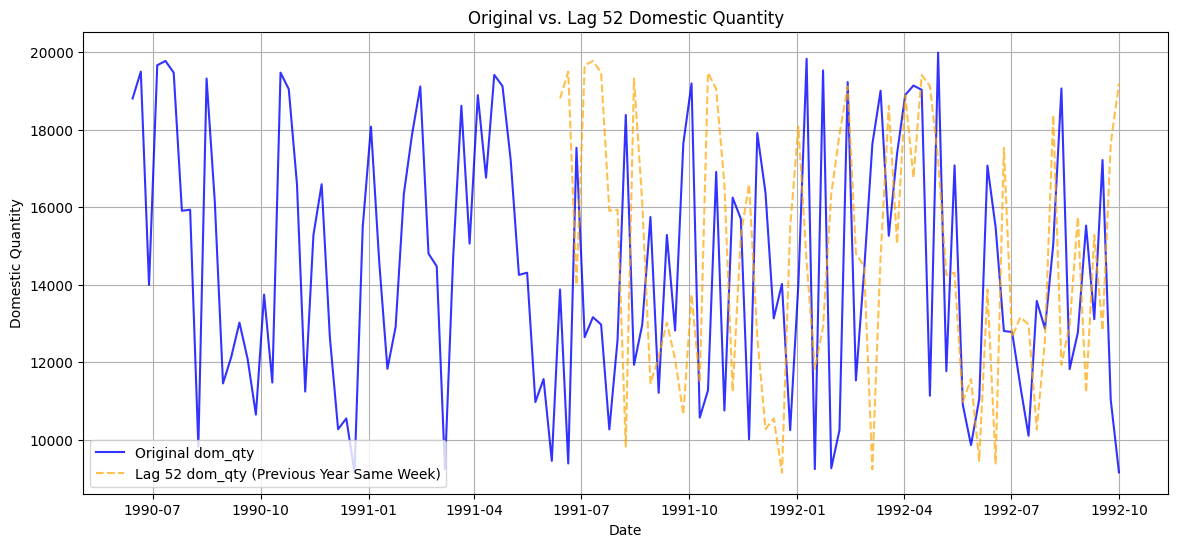

In [9]:

# --- 3. Visualize Engineered Features ---
# Visualize 'dom_qty' alongside a key lag feature.
plt.figure(figsize=(14, 6))
plt.plot(dom_df['dom_qty'], label='Original dom_qty', color='blue', alpha=0.8)
plt.plot(dom_df['lag_52_dom_qty'], label='Lag 52 dom_qty (Previous Year Same Week)', color='orange', linestyle='--', alpha=0.7)
plt.title('Original vs. Lag 52 Domestic Quantity')
plt.xlabel('Date')
plt.ylabel('Domestic Quantity')
plt.legend()
plt.grid(True)
plt.show()


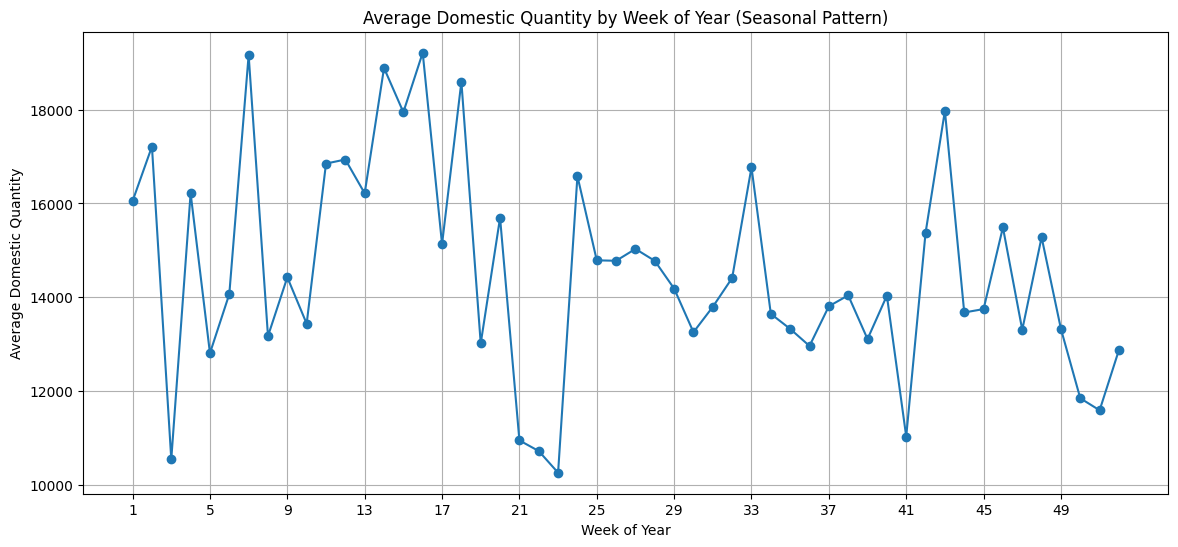

In [10]:

# Visualize the seasonal pattern captured by 'week_of_year' feature (using mean)
plt.figure(figsize=(14, 6))
dom_df.groupby('week_of_year')['dom_qty'].mean().plot(marker='o', linestyle='-')
plt.title('Average Domestic Quantity by Week of Year (Seasonal Pattern)')
plt.xlabel('Week of Year')
plt.ylabel('Average Domestic Quantity')
plt.grid(True)
plt.xticks(np.arange(1, 53, 4)) # Show ticks every 4 weeks
plt.show()

In [11]:

# --- 4. Split Data into Training and Testing Sets ---
# Drop rows with NaNs introduced by lagging before splitting
df_clean = dom_df.dropna()

# Use about 80% for training and 20% for testing
# This ensures that the test set still has future data not seen by the model.
train_size = int(len(df_clean) * 0.8)
train_data_df = df_clean.iloc[0:train_size]
test_data_df = df_clean.iloc[train_size:]


In [12]:

# Separate endogenous variable (y) and exogenous variables (X) for SARIMAX
y_train = train_data_df['dom_qty']
X_train = train_data_df[['lag_1_dom_qty', 'lag_52_dom_qty', 'week_of_year', 'month_of_year', 'year', 'day_of_week']]

y_test = test_data_df['dom_qty']
X_test = test_data_df[['lag_1_dom_qty', 'lag_52_dom_qty', 'week_of_year', 'month_of_year', 'year', 'day_of_week']]

print(f"Training data points (after dropping NaNs): {len(train_data_df)}")
print(f"Testing data points (after dropping NaNs): {len(test_data_df)}\n")


Training data points (after dropping NaNs): 55
Testing data points (after dropping NaNs): 14



In [13]:

# --- 5. Hyperparameter Tuning (Grid Search for SARIMA p,d,q,P,D,Q,s) ---
# Define ranges for non-seasonal parameters (p, d, q)
p_range = d_range = q_range = range(0, 3) # Test 0, 1, 2
non_seasonal_pdq = list(product(p_range, d_range, q_range))

# Define ranges for seasonal parameters (P, D, Q)
P_range = D_range = Q_range = [0, 1] # Typically 0 or 1 for seasonal components
seasonal_period = 52 # Given weekly data, yearly seasonality is 52 weeks
seasonal_pdq = [(x[0], x[1], x[2], seasonal_period) for x in list(product(P_range, D_range, Q_range))]

best_aic = float("inf")
best_order = None
best_seasonal_order = None
best_model_fit = None


In [14]:

print("--- Starting SARIMAX Hyperparameter Tuning (This may take a while) ---")
print("Evaluating models based on AIC. Lower AIC is better.")

for order in non_seasonal_pdq:
    for s_order in seasonal_pdq:
        try:
            model = SARIMAX(y_train,
                            exog=X_train, # Include engineered features as exogenous variables
                            order=order,
                            seasonal_order=s_order,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            model_fit = model.fit(disp=False, maxiter=100) # disp=False suppresses fitting output

            if model_fit.aic < best_aic:
                best_aic = model_fit.aic
                best_order = order
                best_seasonal_order = s_order
                best_model_fit = model_fit
            # print(f"SARIMAX{order}{s_order} - AIC: {model_fit.aic:.2f}") # Uncomment to see progress
        except Exception as e:
            # print(f"SARIMAX{order}{s_order} - Error: {e}") # Uncomment to see errors for specific orders
            continue


--- Starting SARIMAX Hyperparameter Tuning (This may take a while) ---
Evaluating models based on AIC. Lower AIC is better.


In [15]:

if best_order and best_seasonal_order:
    print(f"\n--- Best SARIMAX Order Found: {best_order}{best_seasonal_order} with AIC: {best_aic:.2f} ---\n")
else:
    print("\nWarning: No best SARIMAX order found through grid search. Falling back to default (1,1,1)(1,1,1,s).\n")
    best_order = (1, 1, 1)
    best_seasonal_order = (1, 1, 1, seasonal_period)
    model = SARIMAX(y_train, exog=X_train, order=best_order, seasonal_order=best_seasonal_order,
                    enforce_stationarity=False, enforce_invertibility=False)
    best_model_fit = model.fit(disp=False, maxiter=100)




--- Best SARIMAX Order Found: (1, 0, 0)(0, 1, 0, 52) with AIC: -26.08 ---



In [16]:

# --- 6. Train the Final Model with Best Parameters ---
print("--- Final Best SARIMAX Model Summary ---")
print(best_model_fit.summary())
print("\n")


--- Final Best SARIMAX Model Summary ---
                                     SARIMAX Results                                      
Dep. Variable:                            dom_qty   No. Observations:                   55
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 52)   Log Likelihood                  21.041
Date:                            Mon, 30 Jun 2025   AIC                            -26.083
Time:                                    13:30:19   BIC                            -36.538
Sample:                                06-13-1991   HQIC                           -47.947
                                     - 06-25-1992                                         
Covariance Type:                              opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
lag_1_dom_qty     -0.4505   2.13e-05  -2.12e+04      0.000      -

In [17]:

# --- 7. Forecast / Make Predictions ---
# Predict over the test period using the best fitted model and the test exogenous variables
# The `exog` for prediction must have the same columns and order as during training.
predictions = best_model_fit.predict(start=len(y_train), end=len(df_clean)-1, exog=X_test, typ='levels')



In [18]:

# Assign the index from the test_data_df to predictions for easier plotting
predictions.index = y_test.index

print("--- Forecasted Values (Head) ---")
print(predictions.head())
print("\n")

--- Forecasted Values (Head) ---
WeekStarting
1992-07-02    20139.503439
1992-07-09    18184.343639
1992-07-16    18773.916482
1992-07-23    15968.193260
1992-07-30    13904.878318
Name: predicted_mean, dtype: float64




In [19]:

# --- 8. Metrics Evaluation ---
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)

# Calculate MAPE, handling potential division by zero
def calculate_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0 # Avoid division by zero
    if np.sum(non_zero_mask) == 0:
        return np.nan # Or handle as appropriate if all true values are zero
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

mape = calculate_mape(y_test, predictions)


In [20]:
print("--- Model Evaluation Metrics ---")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")
print(f"MAE (Mean Absolute Error): {mae:.2f}")
print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")
print("\n")

--- Model Evaluation Metrics ---
RMSE (Root Mean Squared Error): 4617.57
MAE (Mean Absolute Error): 3299.61
MAPE (Mean Absolute Percentage Error): 28.78%




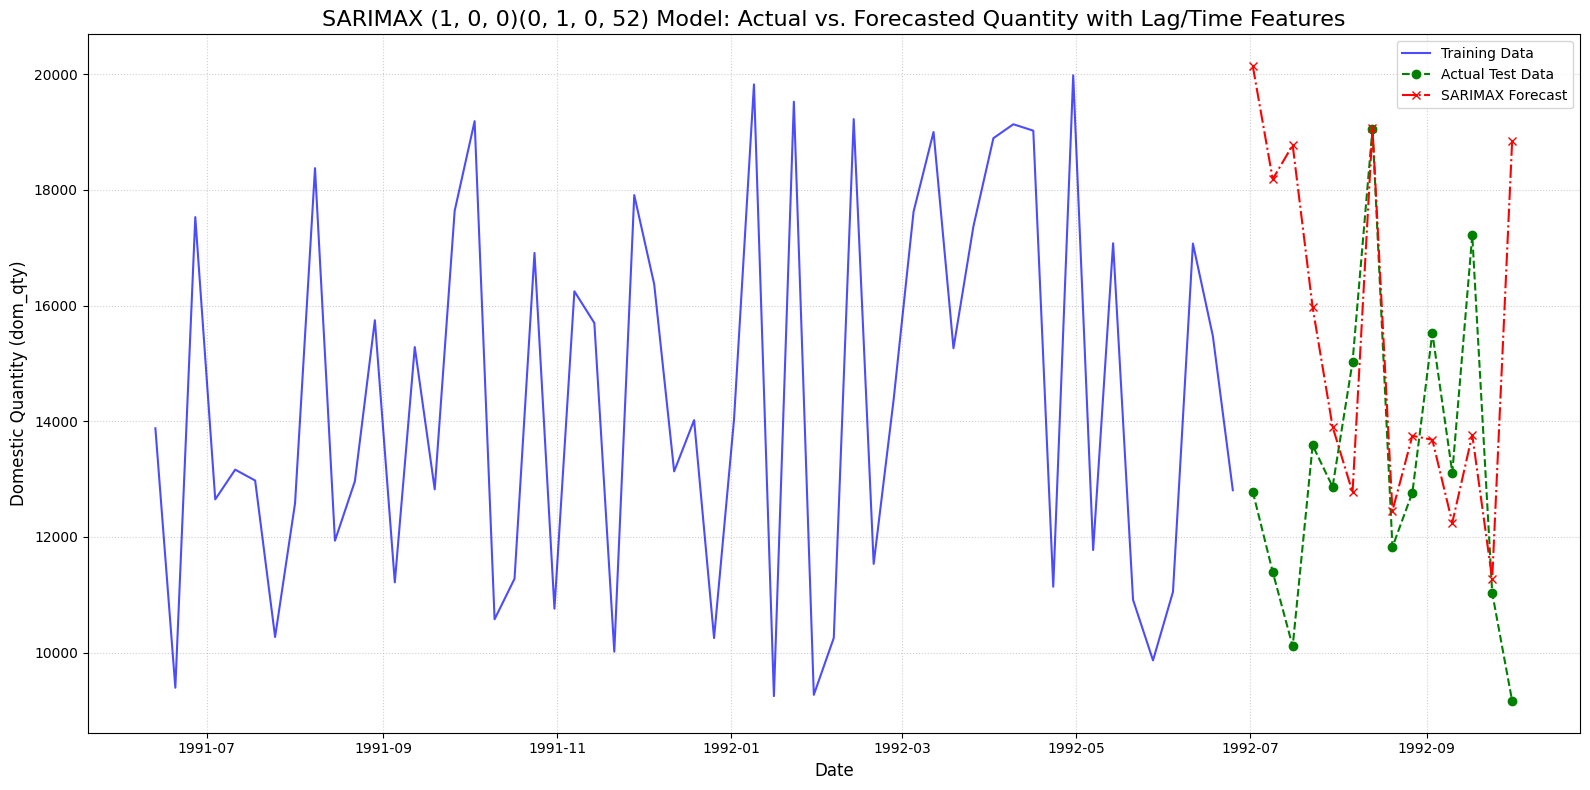

In [21]:
# --- 9. Plotting the Metrics and Forecast ---

# Plot 1: Actual vs. Predicted Values
plt.figure(figsize=(16, 8))
plt.plot(y_train, label='Training Data', color='blue', alpha=0.7)
plt.plot(y_test, label='Actual Test Data', color='green', marker='o', linestyle='--')
plt.plot(predictions, label='SARIMAX Forecast', color='red', marker='x', linestyle='-.')
plt.title(f'SARIMAX {best_order}{best_seasonal_order} Model: Actual vs. Forecasted Quantity with Lag/Time Features', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Domestic Quantity (dom_qty)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()


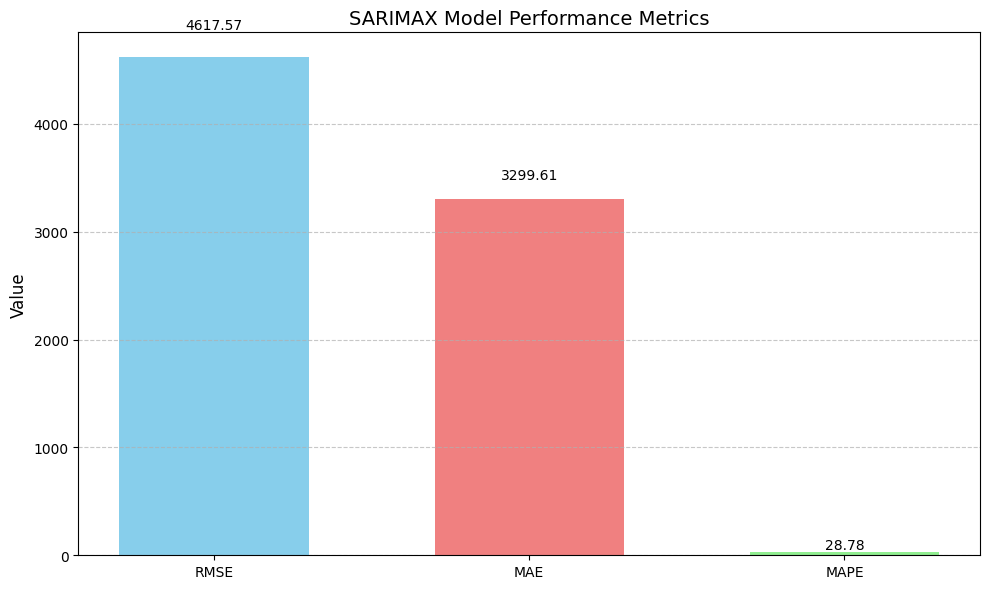

In [22]:
# Plot 2: Evaluation Metrics Bar Chart
metrics_names = ['RMSE', 'MAE', 'MAPE']
metrics_values = [rmse, mae, mape]

plt.figure(figsize=(10, 6))
plt.bar(metrics_names, metrics_values, color=['skyblue', 'lightcoral', 'lightgreen'], width=0.6)
plt.title('SARIMAX Model Performance Metrics', fontsize=14)
plt.ylabel('Value', fontsize=12)
# Add value labels on top of bars
for i, val in enumerate(metrics_values):
    plt.text(i, val + (val*0.05 if val > 0 else -val*0.05), f'{val:.2f}', ha='center', va='bottom', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

--- Residual Analysis for Best SARIMAX Model ---


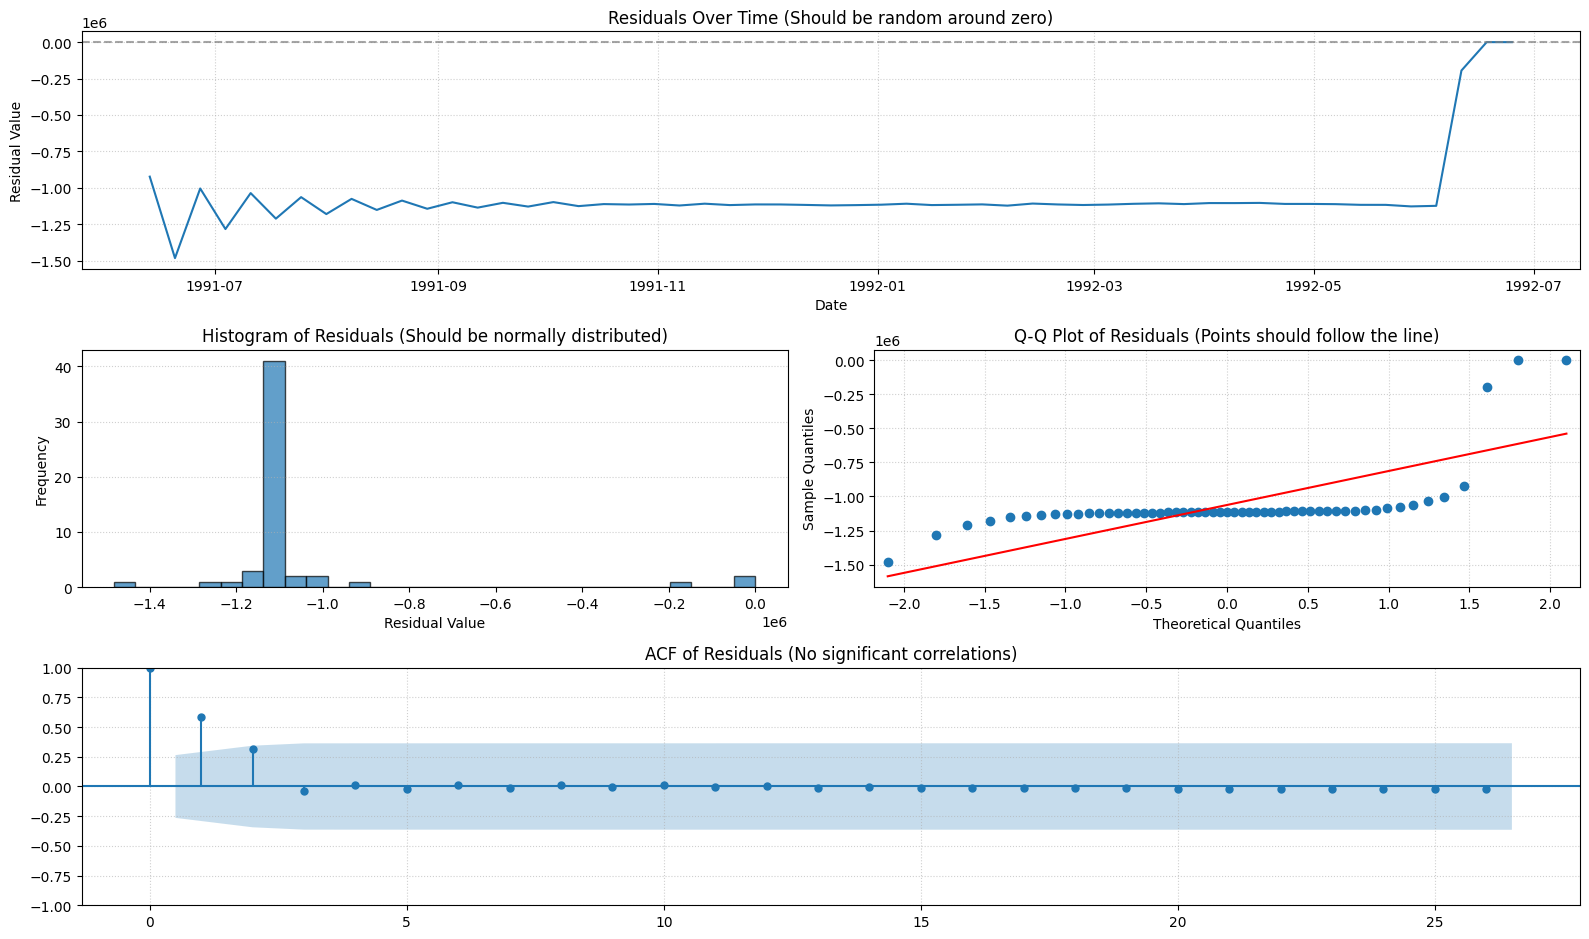

In [23]:

# --- 10. Residual Analysis (Important for checking model fit) ---
print("--- Residual Analysis for Best SARIMAX Model ---")
residuals = best_model_fit.resid # Get residuals from the fitted model

plt.figure(figsize=(16, 10))



# Plot 1: Residuals Over Time
plt.subplot(3, 1, 1)
plt.plot(residuals)
plt.axhline(0, color='grey', linestyle='--', alpha=0.7)
plt.title('Residuals Over Time (Should be random around zero)')
plt.xlabel('Date')
plt.ylabel('Residual Value')
plt.grid(True, linestyle=':', alpha=0.6)



# Plot 2: Histogram of Residuals
plt.subplot(3, 2, 3)
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
plt.title('Histogram of Residuals (Should be normally distributed)')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle=':', alpha=0.6)



# Plot 3: Q-Q Plot of Residuals
plt.subplot(3, 2, 4)
sm.qqplot(residuals, line='s', ax=plt.gca()) # 's' for standardized line
plt.title('Q-Q Plot of Residuals (Points should follow the line)')
plt.grid(True, linestyle=':', alpha=0.6)




# Plot 4: ACF of Residuals
plt.subplot(3, 1, 3)
plot_acf(residuals, lags=min(len(residuals)//2 -1, 52), ax=plt.gca(), title='ACF of Residuals (No significant correlations)')
plt.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()


In [24]:



print("\n--- SARIMAX Forecasting Model with Lag and Time Features Complete ---")
print("Review the plots and metrics to assess the model's performance.")
print("The Residuals plots are crucial: Ideally, they should look like white noise (random, no pattern in ACF).")
print("Achieving very low RMSE/MAPE (e.g., <10% MAPE) for real-world demand data, especially with only sales history, is challenging.")
print("If further reduction is needed, consider incorporating actual exogenous variables (e.g., holiday calendars, promotion flags).")



--- SARIMAX Forecasting Model with Lag and Time Features Complete ---
Review the plots and metrics to assess the model's performance.
The Residuals plots are crucial: Ideally, they should look like white noise (random, no pattern in ACF).
Achieving very low RMSE/MAPE (e.g., <10% MAPE) for real-world demand data, especially with only sales history, is challenging.
If further reduction is needed, consider incorporating actual exogenous variables (e.g., holiday calendars, promotion flags).
